## План работы
### 1. Подготовка данных
#### 1.1. Предобработка количественных признаков
Построение распределения количественных признаков, поиск и обработка аномалий.
#### 1.2. Предобработка качественных признаков
Заполнение и/или удаление пропущенных значений в зависимости от количества пропусков.
#### 1.3. Предобработка количественных признаков
Добавление нужных для расчётов столбцов. Удаление лишних столбцов.
### 2. Обучение моделей
#### 2.1. Библиотека  LightGBM
Обучение модели линейной регрессии на основе градиентного бустинга. Подбор гиперпараметров.
#### 2.2. Библиотека sklearn
Обучение моделей DecisionTreeRegressor, RandomForestRegressor и LinearRegression. Подбор гиперпараметров.
### 3. Анализ моделей
Проверка самой точной и самой быстрой моделей на тестовой выборке.

## Данные
В наличии были следующие данные о подержанных автомобилях:
- дата скачивания анкеты из базы
- тип автомобильного кузова
- год регистрации автомобиля
- тип коробки передач
- мощность
- модель автомобиля
- пробег
- месяц регистрации автомобиля
- тип топлива
- марка автомобиля
- была машина в ремонте или нет
- дата создания анкеты
- количество фотографий автомобиля
- почтовый индекс владельца анкеты (пользователя)

# 1. Подготовка данных

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('../Auto_price/autos.csv')
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 1.1. Предобработка количественных признаков

Максимальная дата регистрации 2016-04-07 14:36:58

0     32913
3     32864
6     29330
4     27958
5     27190
7     25260
10    24520
12    22843
11    22773
9     22431
1     22119
8     21131
2     20365
Name: RegistrationMonth, dtype: int64


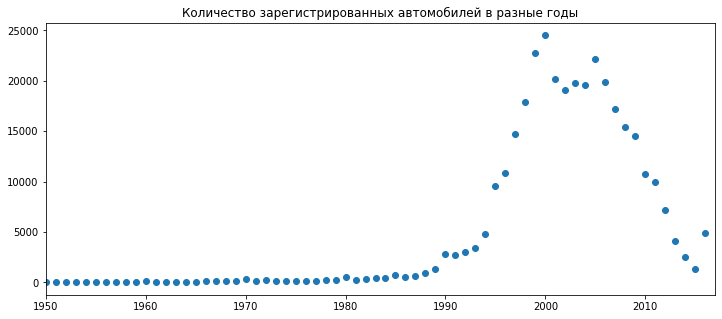

In [2]:
print("Максимальная дата регистрации",data['DateCrawled'].max())
print()
data = data.query('RegistrationYear<=2016')
reg_year_index = data.query('RegistrationYear==2016 and RegistrationMonth>4').index
data = data.query('index not in @reg_year_index')
data['RegistrationYear'].value_counts().plot(marker='o', linestyle='', figsize = (12,5))
plt.xlim(1950,2017)
plt.title('Количество зарегистрированных автомобилей в разные годы')
data = data.query('RegistrationYear>=1980')

print(data['RegistrationMonth'].value_counts())

Обработаем признаки, касающиеся даты и времени: столбцы "Registration Month", "Registration Year", "Date Crawled". Так как самая поздняя дата извлечения данных 2016.04.07, значения года и месяца регистрации не могут быть больше 2016.04. Уберём неподходящие значения из данных. График количества автомобилей, зарегистрированных в разные годы, показывает, что целесообразно взять данные только с 1980 года, когда начался стабильный рост количества зарегистрированных автомобилей. Кроме того, поиск аномалий в столбце 'RegistrationMonth' выявляет аномальное значение 0, однако для дальнейших расчётов это не критично.

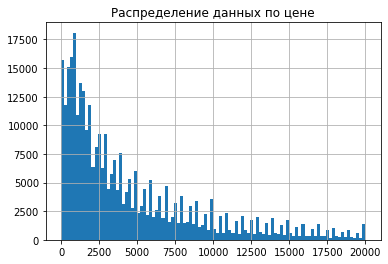

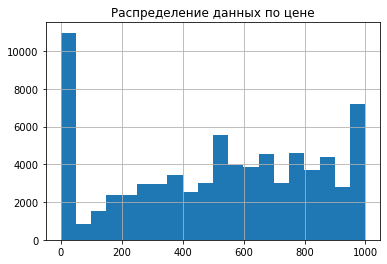

In [3]:
data['Price'].hist(bins=100)
plt.title('Распределение данных по цене')
plt.show()
data.query('Price<1000')['Price'].hist(bins=20)
plt.title('Распределение данных по цене')
plt.show()
data = data.query('Price!=0')

Обработаем столбец "Price". Построение распределения данных по цене выявляет аномалию в виде нулевых значений. Уберём эти данные.

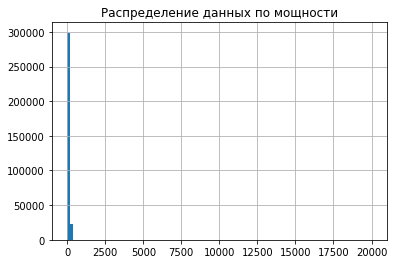

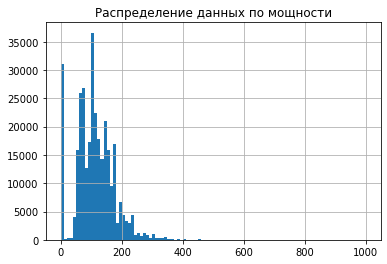

Строк с нулевым значением мощности 9.59%


In [4]:
data['Power'].hist(bins=100)
plt.title('Распределение данных по мощности')
plt.show()
data.query('Power<1000')['Power'].hist(bins=100)
plt.title('Распределение данных по мощности')
plt.show()
print("Строк с нулевым значением мощности {:.2%}".format(len(data.query('Power==0'))/len(data)))
data=data.query('Power<400')

def fill_power(row):
    """
    Заполняет пропуски в стобце 'Power' средним значением для данной модели
    """
    power=row['Power']
    model=row['Model']
    if power==0:
        power=data.query('Model==@model and Power!=0')['Power'].mean()
    return power

data['Power']=data.apply(fill_power, axis=1)
data=data.query('Power!=0')

Обработаем столбец "Power". Построение распределения данных по мощности выявляет аномалию в виде нулевых значений. Таких данных довольно много, около 10%, поэтому представляется нецелесообразным их удалять. Заполним их средним значением для данной марки автомобиля.

Text(0.5, 1.0, 'Распределение данных по километражу')

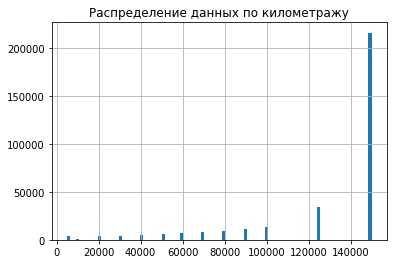

In [5]:
data['Kilometer'].hist(bins=100)
plt.title('Распределение данных по километражу')

Обработаем столбец "Kilometer". Построение распределения данных по километражу явных аномалий не выявило.

### 1.2. Предобработка категориальных признаков

In [6]:
print("Количество пропущенных значений в столбцах:")
for _ in ['VehicleType','Gearbox','Model','FuelType','NotRepaired']:
    print(_, "{:.2%}".format(data[_].isna().sum()/len(data)))

data = data.dropna(subset=['VehicleType','Model','Gearbox'])
data = data.fillna(0)

def fill_fuel_type(row):
    """
    Заполняет пропуски в стобце 'FuelType' самым частотным значением для данной модели
    """
    fuel_type = row['FuelType']
    model = row['Model']
    if fuel_type == 0:
        fuel_type = data.query('Model==@model')['FuelType'].value_counts().index[0]
    return fuel_type

data['FuelType']=data.apply(fill_fuel_type, axis=1)

Количество пропущенных значений в столбцах:
VehicleType 4.73%
Gearbox 4.55%
Model 4.44%
FuelType 6.77%
NotRepaired 17.72%


In [7]:
def fill_not_repaired(row):
    """
    Заполняет пропуски в стобце 'NotRepaired' самым частотным значением для данной модели
    """
    not_repaired = row['NotRepaired']
    year = row['RegistrationYear']
    if not_repaired == 0:
        not_repaired = data.query('RegistrationYear==@year')['NotRepaired'].value_counts().index[0]
    return not_repaired

data['NotRepaired']=data.apply(fill_not_repaired, axis=1)

Перейдём к обработке категориальных признаков. Пропуски присутствуют в столбцах "VehicleType", "Gearbox" и "Model" (эти значения предсказать невозможно, удалим эти пропуски), а также "FuelType" и "NotRepaired" (эти значения представляется логичным заполнить самым частотным значением в соответствие с моделью и годом выпуска).

### 1.3. Подготовка данных для анализа

In [8]:
print(data.duplicated().sum())
data = data.drop_duplicates()

data['TotalMonths'] = (2016-data['RegistrationYear'])*12 + data['RegistrationMonth']
data = data.drop(['DateCreated','DateCrawled','LastSeen','PostalCode','RegistrationMonth','RegistrationYear'], axis=1)

5


Удалим дубликаты. Создадим столбец 'TotalMonths', где посчитаем количество месяцев от этой даты до даты регистрации, с учетом того, что самая поздняя дата регистрации автомобиля это 2016.04. После этого удалим ненужные более для расчётов столбцы 'DateCreated', 'DateCrawled', 'LastSeen', 'PostalCode', 'RegistrationMonth', 'RegistrationYear'.

# 2. Обучение моделей

### 2.1. Библиотека LightGBM

In [9]:
import warnings
warnings.filterwarnings('ignore')

data_lgb = data
print(data_lgb.info())
for i in ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']:
    data_lgb[i] = pd.Categorical(data_lgb[i])
print()
print(data_lgb.info())

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target_lgb = data_lgb['Price']
features_lgb = data_lgb.drop('Price', axis=1)

def split_data(features,target):
    """
    Стандартизирует данные и делит их на тренировочную, валидационную и тестовую выборки
    """
    features_trainvalid, features_test, target_trainvalid, target_test = train_test_split(features,target,
                                                                                          test_size=0.2,random_state=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features_trainvalid,target_trainvalid,
                                                                                  test_size=0.25, random_state=1)
    numeric = ['Power','Kilometer','TotalMonths']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_valid, features_test, target_train, target_valid, target_test

features_train_lgb,features_valid_lgb,features_test_lgb,target_train_lgb,target_valid_lgb,target_test_lgb = split_data(features_lgb,target_lgb)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286983 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             286983 non-null  int64  
 1   VehicleType       286983 non-null  object 
 2   Gearbox           286983 non-null  object 
 3   Power             286983 non-null  float64
 4   Model             286983 non-null  object 
 5   Kilometer         286983 non-null  int64  
 6   FuelType          286983 non-null  object 
 7   Brand             286983 non-null  object 
 8   NotRepaired       286983 non-null  object 
 9   NumberOfPictures  286983 non-null  int64  
 10  TotalMonths       286983 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 26.3+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286983 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            -------------

Данные для библиотек LightGBM и sklearn будем подготавливать отдельно, так как LightBGM может работать с категориальным типом данных, в отличие от моделей из sklearn. Cоздадим копию исходной таблицы data_lgb, в которой присвоим всем данным типа object тип category. Затем стандартизируем данные и разделим их на тренировочную, валидационную и тестовую выборки.

In [10]:
from lightgbm import LGBMRegressor

for i in range(5,18,2):
    time_0 = datetime.datetime.now()
    model = LGBMRegressor(num_iterations=50, verbose=-1, metric='rmse',
                          max_depth=i, num_leaves=2**(i-1), random_state=1)
    model.fit(features_train_lgb, target_train_lgb, eval_set=(features_valid_lgb, target_valid_lgb), verbose=10)
    time_1 = datetime.datetime.now()
    print("Время выполнения {}".format((time_1-time_0)), "для глубины", i)

[10]	valid_0's rmse: 2574.19
[20]	valid_0's rmse: 1976.05
[30]	valid_0's rmse: 1782.52
[40]	valid_0's rmse: 1706.38
[50]	valid_0's rmse: 1672.01
Время выполнения 0:00:00.661211 для глубины 5
[10]	valid_0's rmse: 2387.68
[20]	valid_0's rmse: 1798.71
[30]	valid_0's rmse: 1644.49
[40]	valid_0's rmse: 1588.27
[50]	valid_0's rmse: 1565.42
Время выполнения 0:00:00.882640 для глубины 7
[10]	valid_0's rmse: 2289.12
[20]	valid_0's rmse: 1703.57
[30]	valid_0's rmse: 1568.47
[40]	valid_0's rmse: 1524.8
[50]	valid_0's rmse: 1505.78
Время выполнения 0:00:01.402250 для глубины 9
[10]	valid_0's rmse: 2238.74
[20]	valid_0's rmse: 1655.36
[30]	valid_0's rmse: 1531.39
[40]	valid_0's rmse: 1497.09
[50]	valid_0's rmse: 1483.72
Время выполнения 0:00:02.626976 для глубины 11
[10]	valid_0's rmse: 2219.51
[20]	valid_0's rmse: 1634.22
[30]	valid_0's rmse: 1515.09
[40]	valid_0's rmse: 1483.89
[50]	valid_0's rmse: 1474.44
Время выполнения 0:00:04.569782 для глубины 13
[10]	valid_0's rmse: 2211.15
[20]	valid_0's 

Подберём гиперпараметры для модели регрессии на основе LIghtGBM на небольшом количестве итераций, начиная с max_depth (при этом num_leaves поставим равным 2^(max_depth-1) в соответствии с рекомендациями из документации LightBGM). Перебор значений показывает, что после max_depth = 13 rmse уменьшается незначительно, но резко возрастает время выполнения. В дальнейшем будем использовать max_depth = 13 и num_leaves = 4000 (примерно 2^12).

In [11]:
model = LGBMRegressor(num_iterations=1000, verbose=-1, metric='rmse',
                      max_depth = 13, num_leaves = 4000, random_state=1)
model.fit(features_train_lgb, target_train_lgb, eval_set=(features_valid_lgb, target_valid_lgb), verbose=10)

[10]	valid_0's rmse: 2219.51
[20]	valid_0's rmse: 1634.22
[30]	valid_0's rmse: 1515.09
[40]	valid_0's rmse: 1483.89
[50]	valid_0's rmse: 1474.44
[60]	valid_0's rmse: 1470.44
[70]	valid_0's rmse: 1467.8
[80]	valid_0's rmse: 1466.27
[90]	valid_0's rmse: 1465.01
[100]	valid_0's rmse: 1464.45
[110]	valid_0's rmse: 1462.89
[120]	valid_0's rmse: 1461.83
[130]	valid_0's rmse: 1461.1
[140]	valid_0's rmse: 1459.79
[150]	valid_0's rmse: 1459.4
[160]	valid_0's rmse: 1458.94
[170]	valid_0's rmse: 1458.74
[180]	valid_0's rmse: 1458.44
[190]	valid_0's rmse: 1458.22
[200]	valid_0's rmse: 1458.3
[210]	valid_0's rmse: 1458.03
[220]	valid_0's rmse: 1458.01
[230]	valid_0's rmse: 1458.03
[240]	valid_0's rmse: 1457.93
[250]	valid_0's rmse: 1457.83
[260]	valid_0's rmse: 1457.65
[270]	valid_0's rmse: 1457.45
[280]	valid_0's rmse: 1457.36
[290]	valid_0's rmse: 1457.38
[300]	valid_0's rmse: 1457.35
[310]	valid_0's rmse: 1457.1
[320]	valid_0's rmse: 1457.41
[330]	valid_0's rmse: 1457.28
[340]	valid_0's rmse: 14

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=13,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1,
              num_iterations=1000, num_leaves=4000, objective=None,
              random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbose=-1)

Подберём необходимое количество итераций. RMSE остаётся приблизительно постоянным при 200-350 итерациях. Логично взять 230 итераций для модели, чтобы уменьшить время обучения. Таким образом, оптимальные параметры для регрессии с помощью LightBGM это 200 итераций, максимальная глубина 13, число листьев 4000.

### 2.2. Библиотека sklearn

In [12]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

features_train,features_valid,features_test,target_train,target_valid,target_test = split_data(features,target)

Закодируем данные с помощью дамми-ловушки и разделим на тренировочную, валидационную и тестовую выборку. Затем протестируем модели LinearRegression, DecisionTreeRegressor и RandomForestRegressor из библиотеки sklearn. Для моделей решающего дерева и случайного леса также подберём оптимальные гиперпараметры (максимальную глубину и число деревьев соответственно).

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

model_lr = LinearRegression()
time_0 = datetime.datetime.now()
model_lr.fit(features_train, target_train)
time_1 = datetime.datetime.now()
predicted_valid = model_lr.predict(features_valid)
time_2 = datetime.datetime.now()
rmse = mse(target_valid, predicted_valid)**0.5

print("Для линейной регрессии rmse={:.0f};".format(rmse),
      "время обучения {};".format(time_1-time_0),
      "время предсказания {}".format(time_2-time_1))

Для линейной регрессии rmse=2346; время обучения 0:00:03.399717; время предсказания 0:00:00.130650


In [14]:
from sklearn.tree import DecisionTreeRegressor
print("Для регрессии методом решающего дерева:")

for i in range(5,21,2):
    model_dtr = DecisionTreeRegressor(max_depth=i,random_state=1)
    time_0 = datetime.datetime.now()
    model_dtr.fit(features_train, target_train)
    time_1 = datetime.datetime.now()
    predicted_valid = model_dtr.predict(features_valid)
    time_2 = datetime.datetime.now()
    rmse = mse(target_valid, predicted_valid)**0.5
    print("При max_depth={}".format(i),
          "rmse={:.0f};".format(rmse), "время обучения {};".format(time_1-time_0),
          "время предсказания {}".format(time_2-time_1))

Для регрессии методом решающего дерева:
При max_depth=5 rmse=2287; время обучения 0:00:02.537246; время предсказания 0:00:00.121652
При max_depth=7 rmse=2101; время обучения 0:00:03.049811; время предсказания 0:00:00.130681
При max_depth=9 rmse=1972; время обучения 0:00:04.032191; время предсказания 0:00:00.203452
При max_depth=11 rmse=1884; время обучения 0:00:04.439131; время предсказания 0:00:00.123669
При max_depth=13 rmse=1823; время обучения 0:00:04.698469; время предсказания 0:00:00.130620
При max_depth=15 rmse=1803; время обучения 0:00:05.734705; время предсказания 0:00:00.168514
При max_depth=17 rmse=1813; время обучения 0:00:05.381641; время предсказания 0:00:00.127659
При max_depth=19 rmse=1816; время обучения 0:00:05.194114; время предсказания 0:00:00.122671


In [15]:
from sklearn.ensemble import RandomForestRegressor
print("Для регрессии методом случайного леса:")

for i in range(10,31,10):
    model_rfr = RandomForestRegressor(max_depth=15, n_estimators=i,random_state=1)
    time_0 = datetime.datetime.now()
    model_rfr.fit(features_train, target_train)
    time_1 = datetime.datetime.now()
    predicted_valid = model_rfr.predict(features_valid)
    time_2 = datetime.datetime.now()
    rmse = mse(target_valid, predicted_valid)**0.5
    print("При n_estimators={}".format(i),
          "rmse={:.0f};".format(rmse), "время обучения {};".format(time_1-time_0),
          "время предсказания {}".format(time_2-time_1))

Для регрессии методом случайного леса:
При n_estimators=10 rmse=1640; время обучения 0:00:32.088205; время предсказания 0:00:00.254350
При n_estimators=20 rmse=1623; время обучения 0:01:05.524110; время предсказания 0:00:00.305154
При n_estimators=30 rmse=1619; время обучения 0:01:30.266689; время предсказания 0:00:00.410901


### Вывод

Из всех протестированных моделей библиотеки sklearn ни одна ни даёт такой же результат, как и модель регрессии библиотеки lightGBM. Во всех случаях RMSE получается выше (2346 для линейной регрессии, 1803 у решающего дерева и 1619 у случайного леса), при этом минимальное время обучения моделей sklearn сопоставимо со временем обучения модели lightGBM. Таким образом, оптимальной для дальнейшего тестирования представляется логичным выбрать модель регрессии на основе градиентного бустинга. 

# 3. Анализ моделей

In [16]:
model_lgbm = LGBMRegressor(num_iterations=200, verbose=-1, metric='rmse',
                           max_depth=13, num_leaves=4000, random_state=1)

features_trainvalid_lgb = pd.concat([features_train_lgb,features_valid_lgb], ignore_index=True)
target_trainvalid_lgb = pd.concat([target_train_lgb,target_valid_lgb], ignore_index=True)

del features_train_lgb
del features_valid_lgb
del target_train_lgb
del target_valid_lgb
del features_train
del features_valid
del target_train
del target_valid

In [17]:
time_0 = datetime.datetime.now()
model_lgbm.fit(features_trainvalid_lgb, target_trainvalid_lgb)
time_1 = datetime.datetime.now()
predicted_test_lgb = model_lgbm.predict(features_test_lgb)
time_2 = datetime.datetime.now()
rmse = mse(target_test_lgb, predicted_test_lgb)**0.5

print("Для LightGBM rmse={:.0f};".format(rmse),
      "время обучения {};".format(time_1-time_0),
      "время предсказания {}".format(time_2-time_1))

Для LightGBM rmse=1421; время обучения 0:00:08.628928; время предсказания 0:00:01.015286


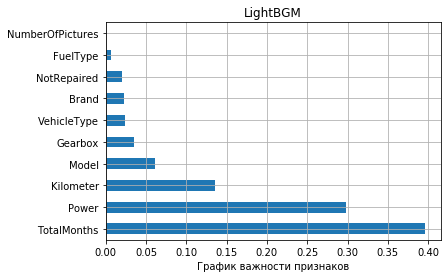

In [18]:
def feature_importances_plot(the_model,features,title,number):
    """
    Строит график важности признаков
    """
    importances = pd.DataFrame({'importance':the_model.feature_importances_},
                               index=features.columns)
    importances = importances.sort_values(by='importance', ascending=False)
    importances['feature_percentage']=importances['importance']/importances['importance'].sum()
    importances['feature_percentage'].head(number).plot.barh(title=title, grid=True)
    plt.xlabel('График важности признаков')
    plt.show()
    
feature_importances_plot(model_lgbm,features_trainvalid_lgb,'LightBGM',
                         len(features_trainvalid_lgb))

Обучим модель на объединённых тренировочной и валидационной выборках и протестируем на тестовой выборке, предварительно удалив все промежуточные переменные во избежание перегрузки кернела. Затем построим график важности признаков.

## Общий вывод

Модель градиентного бустинга на основе LightGMB показывает наилучшую метрику RMSE, равную 1422, при этом время обучения модели составляет 9 секунд, а время предсказания 1 секунду. При этом важно отметить, что LightGBM строит предсказание преимущественно на основе сразу нескольких признаков, а именно, возраста автомобиля, мощности двигателя, километража и модели.